## 1. 檢查 GPU
首先確定我們可以使用 GPU。我們可以使用 nvidia-smi 命令來檢查。如果出現錯誤訊息，請前往「編輯」->「筆記本設定」->「硬體加速器」，將其設置為 GPU，然後點擊保存。

In [1]:
!nvidia-smi

Sat May 11 09:02:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 2. 訓練自己的 YOLOv8 模型
YOLOv8 模型是由 Ultralytics 公司基於 YOLOv5 和 YOLOv7 模型進行開發的，繼承了這兩個版本的優點，同時做出了一系列改進，以提供更高效和準確的物件偵測能力。YOLOv8 已經在 coco 數據集上訓練過，該數據集包含 80 個可預測的類別。我們將獲取這些預訓練權重，以便可以在這些預訓練類別上運行物件辨識。您可以從以下連結查看預訓練的 YOLOv8 權重可以檢測到哪些類別。

- [COCO CLASSES](http://cocodataset.org/#explore)

| Model                                                                                | size<br><sup>(pixels) | mAP<sup>val<br>50-95 | Speed<br><sup>CPU ONNX<br>(ms) | Speed<br><sup>A100 TensorRT<br>(ms) | params<br><sup>(M) | FLOPs<br><sup>(B) |
| ------------------------------------------------------------------------------------ | --------------------- | -------------------- | ------------------------------ | ----------------------------------- | ------------------ | ----------------- |
| [YOLOv8n](https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8n.pt) | 640                   | 37.3                 | 80.4                           | 0.99                                | 3.2                | 8.7               |
| [YOLOv8s](https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8s.pt) | 640                   | 44.9                 | 128.4                          | 1.20                                | 11.2               | 28.6              |
| [YOLOv8m](https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8m.pt) | 640                   | 50.2                 | 234.7                          | 1.83                                | 25.9               | 78.9              |
| [YOLOv8l](https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8l.pt) | 640                   | 52.9                 | 375.2                          | 2.39                                | 43.7               | 165.2             |
| [YOLOv8x](https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8x.pt) | 640                   | 53.9                 | 479.1                          | 3.53                                | 68.2               | 257.8             |
### 2.1 安裝 ultralytics
Ultralytics YOLOv8 是由 Ultralytics 開發的 YOLO（You Only Look Once）物體檢測和圖像分割模型的最新版本。 在這份程式中，我們將介紹如何訓練一個 YOLOv8 物件偵測模型。

In [2]:
!pip install ultralytics==8.0.196 -q

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.8/78.2 GB disk)


### 2.2 使用 Roboflow 匯入資料集

In [3]:
!pip install roboflow --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.1 MB/s eta 0:00:00


In [4]:
from roboflow import Roboflow
rf = Roboflow(api_key="8Z4ck3hgIdLkrbFet3Yj")
project = rf.workspace("yolo-zbpxw").project("screw-fmzbb")
version = project.version(4)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to screw-4 in yolov8:: 100%|██████████| 122/122 [00:00<00:00, 6456.36it/s]


### 2.3 訓練模型



In [5]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

results = model.train(data=f"{dataset.location}/data.yaml", epochs=100, imgsz=640)

100%|██████████| 6.23M/6.23M [00:00<00:00, 75.6MB/s]
New https://pypi.org/project/ultralytics/8.2.12 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/screw-4/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False

## 2.4 觀察訓練結果

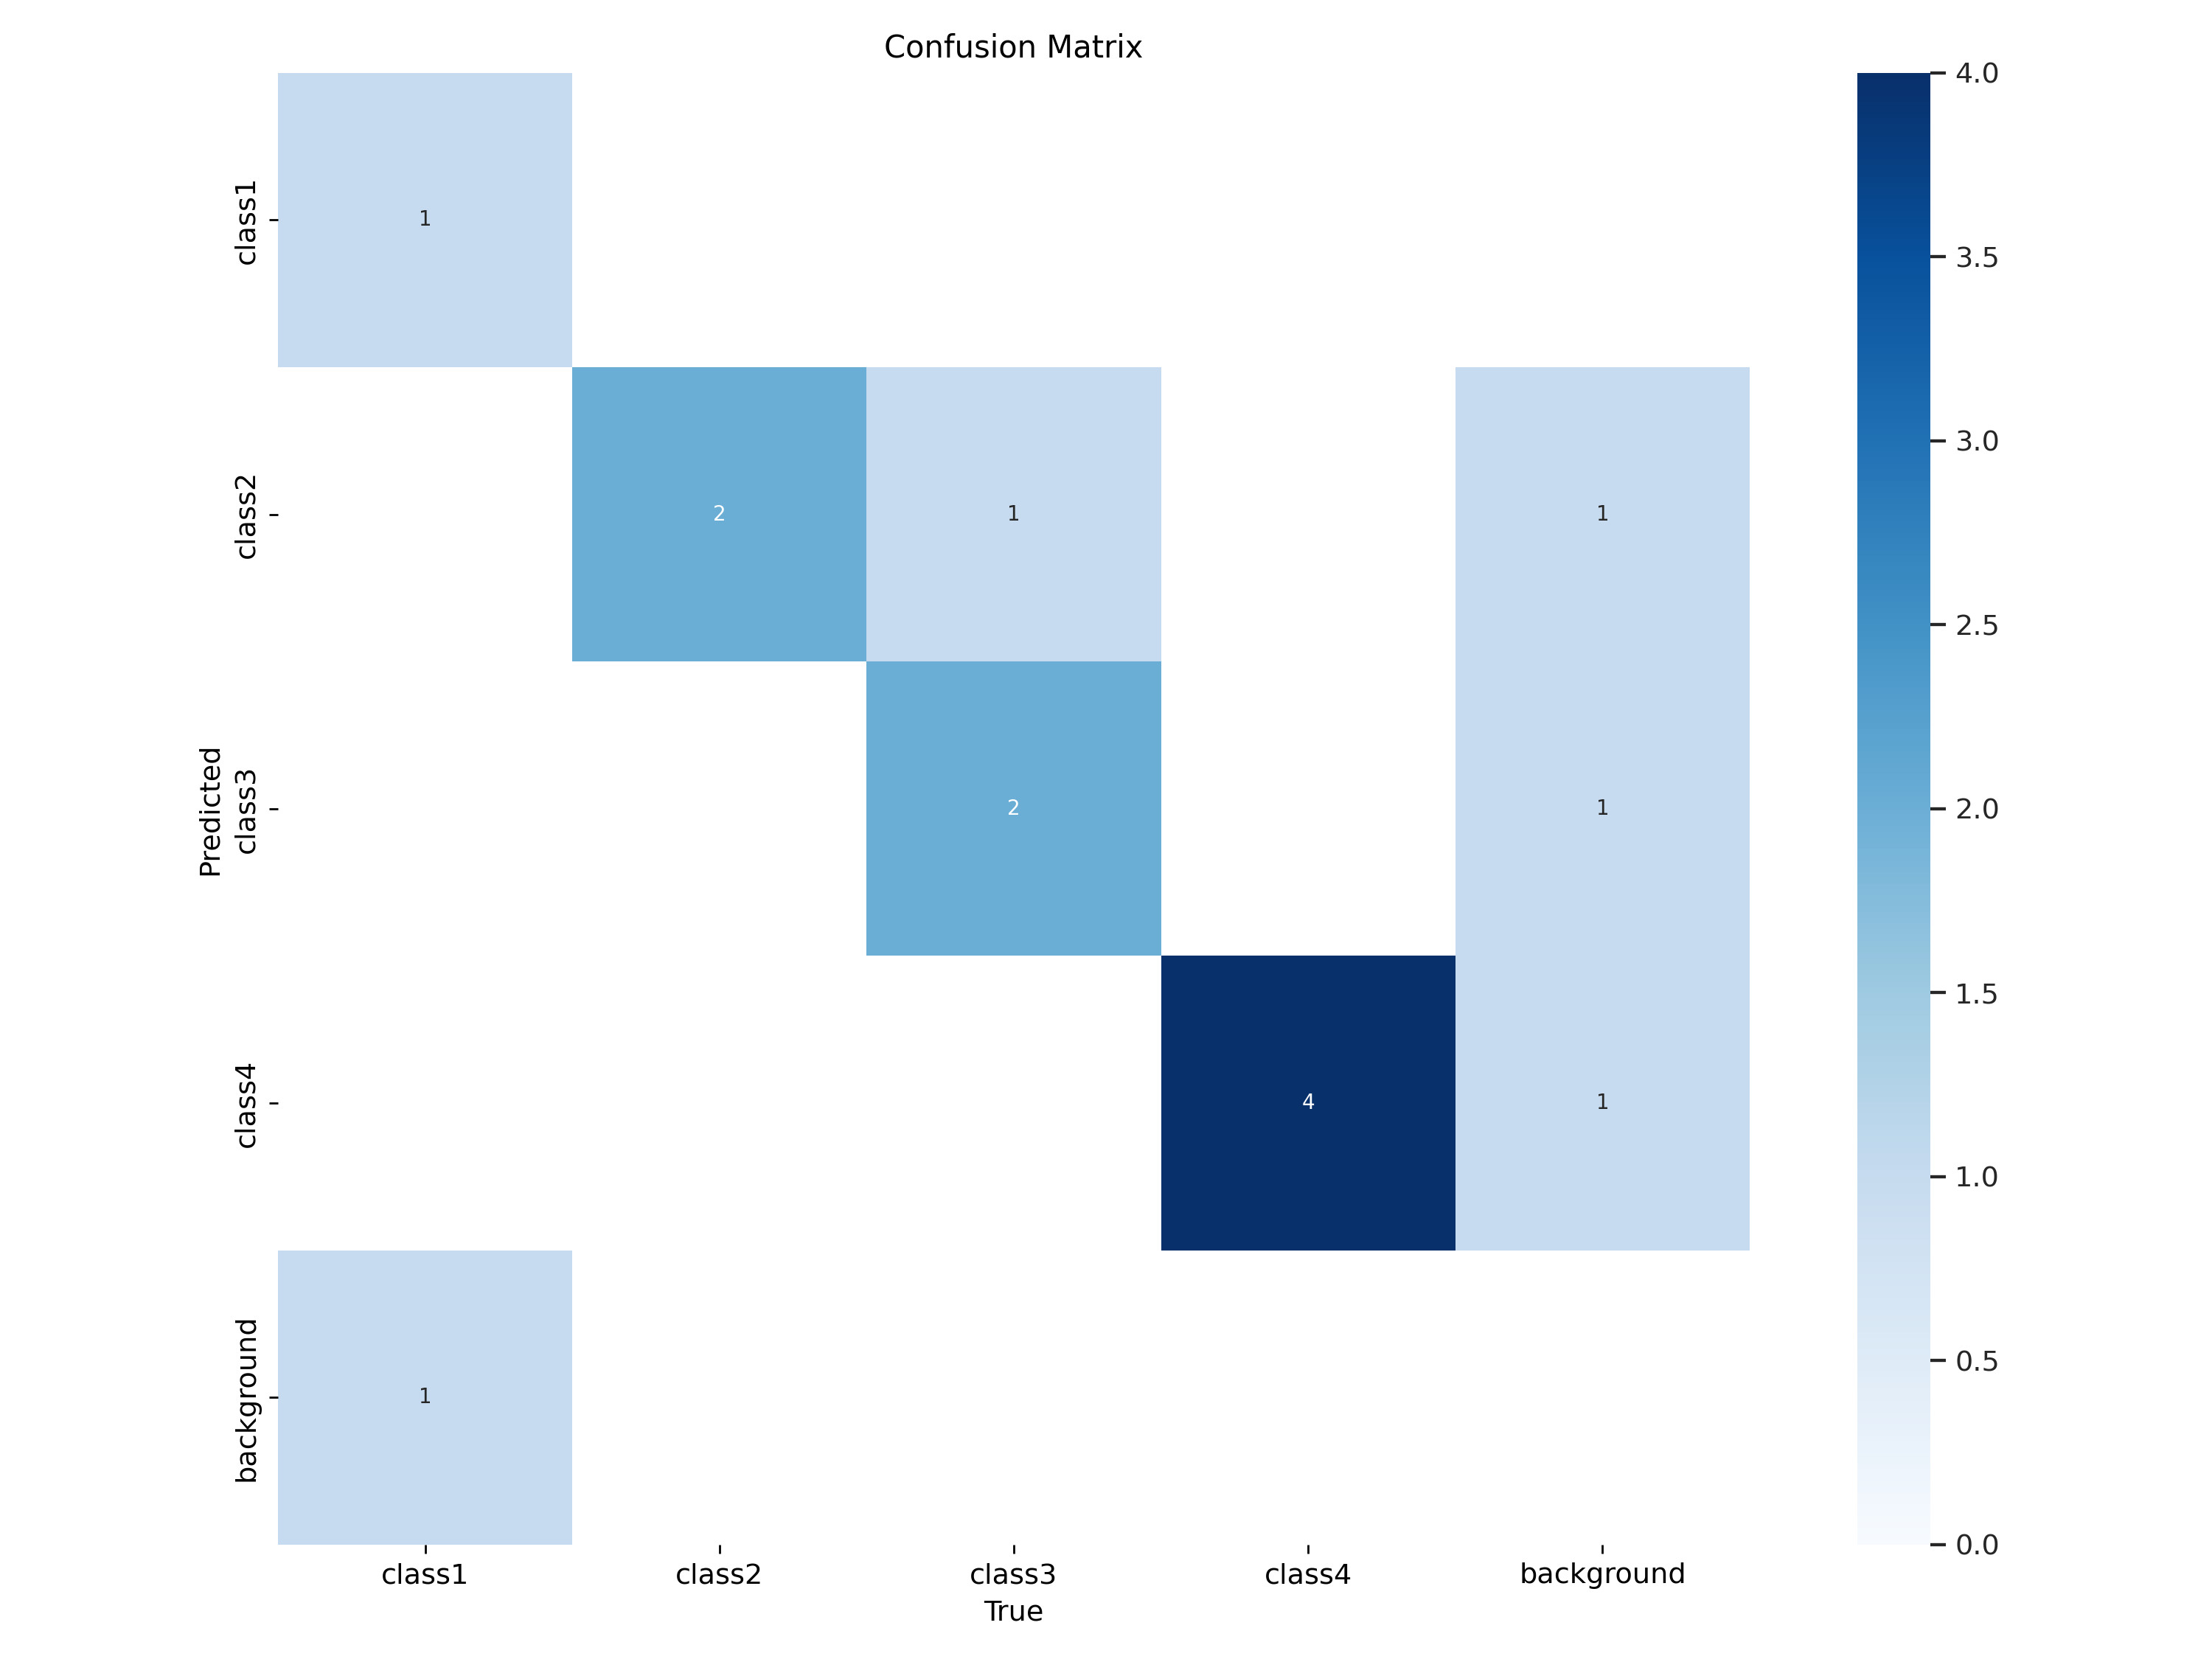

In [12]:
from PIL import Image

Image.open('runs/detect/train/confusion_matrix.png')

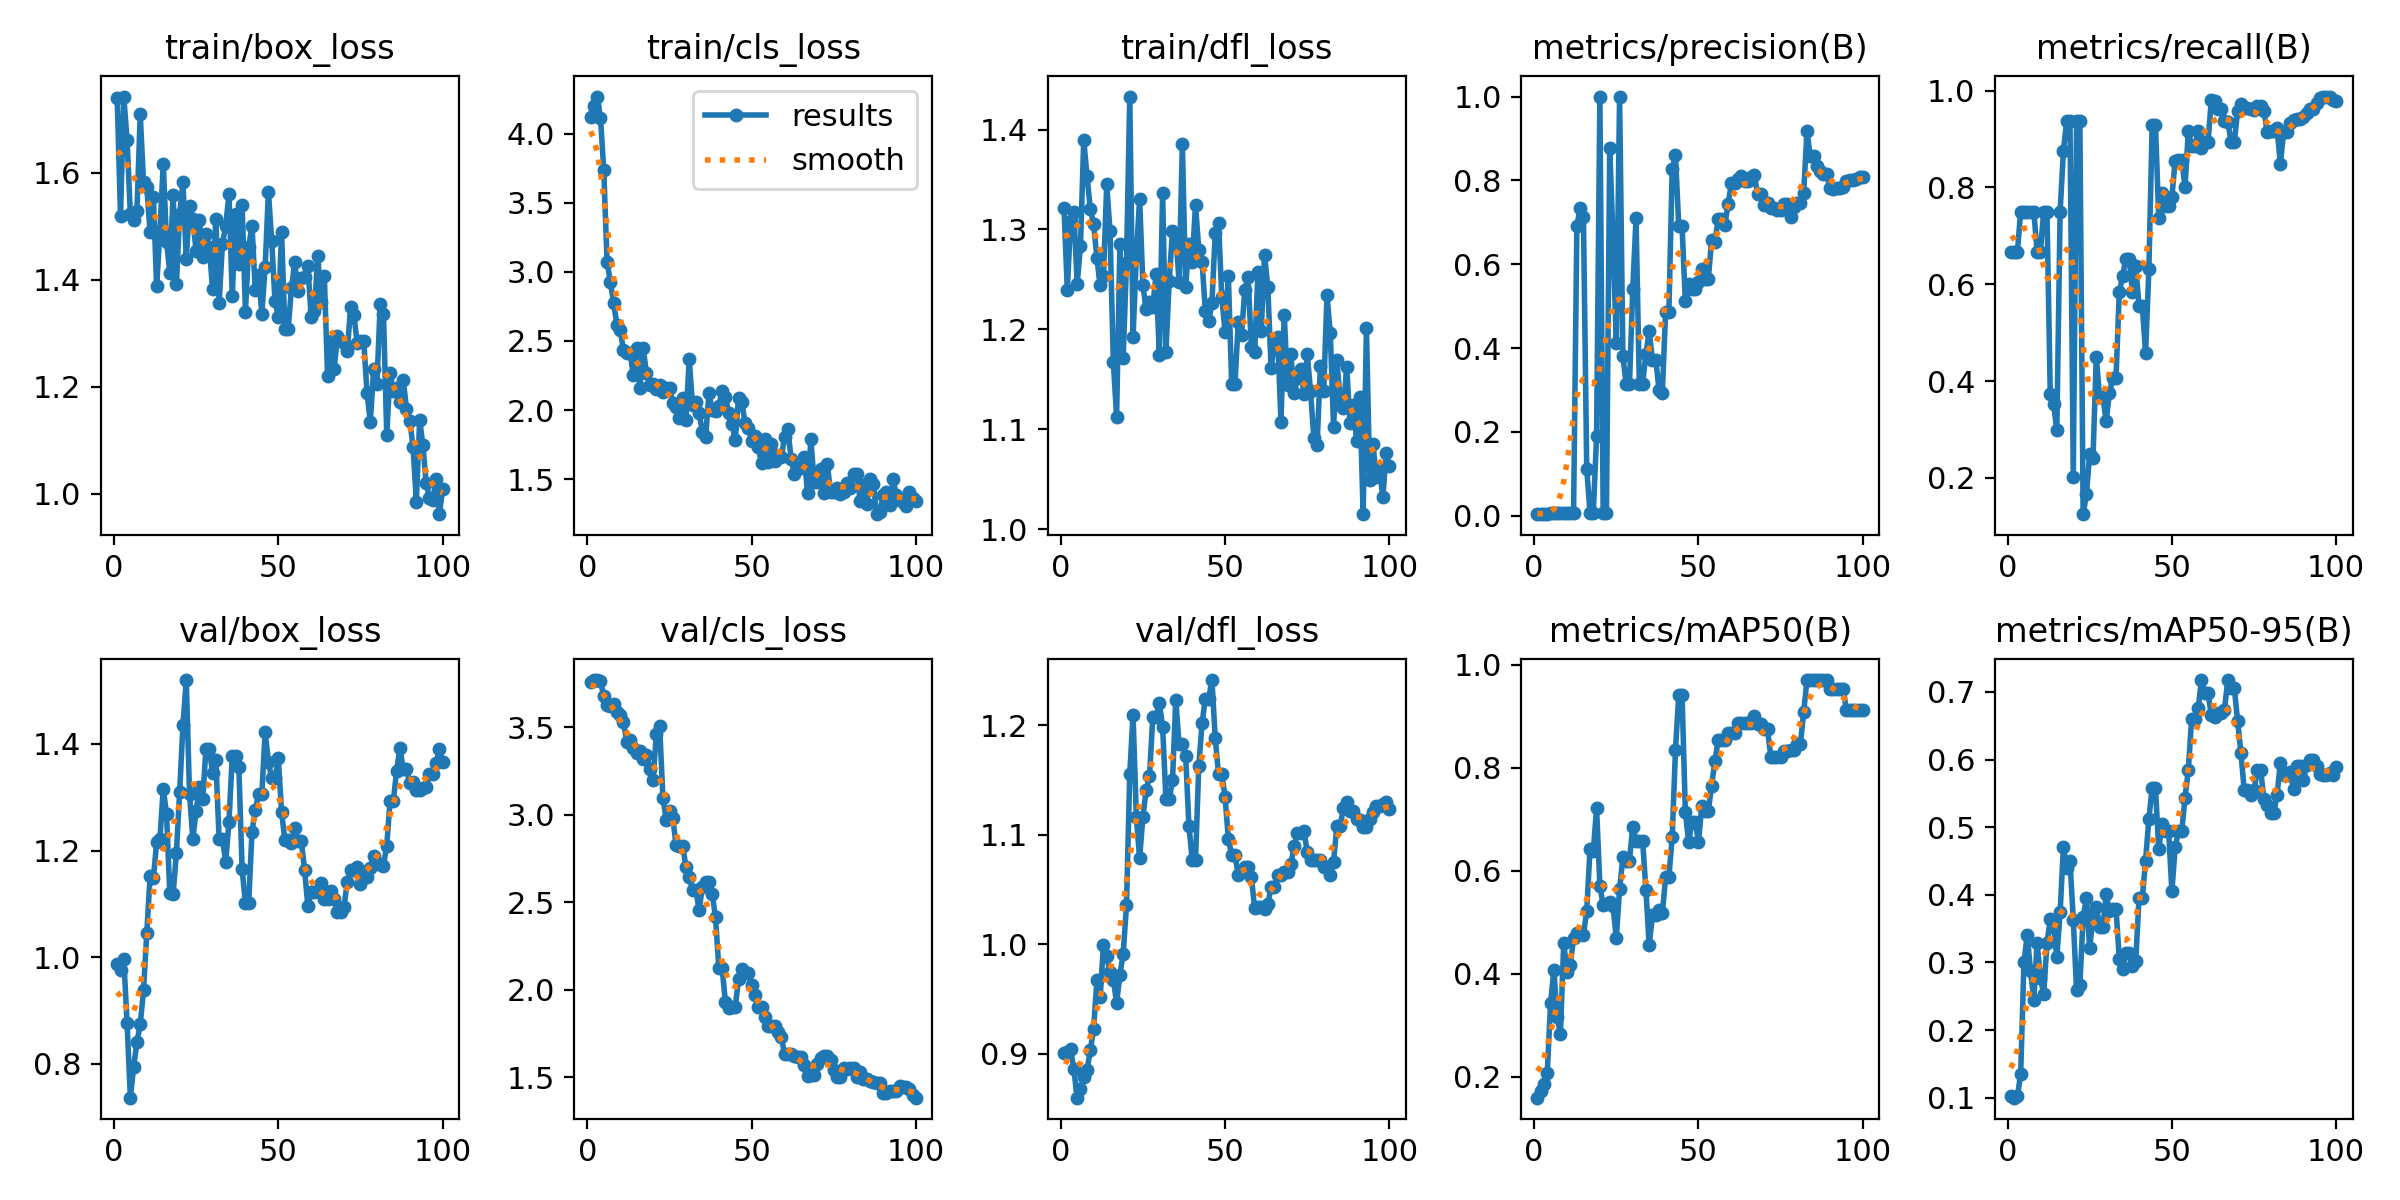

In [13]:
Image.open('runs/detect/train/results.png')

## 2.5 測試

### 2.5.1 使用 CLI 指令預測(方法一)

In [10]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [9]:
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt conf=0.25 source=/content/screw-4/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg save=True

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs

image 1/1 /content/screw-4/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg: 640x640 1 class1, 1 class2, 1 class3, 6 class4s, 10.9ms
Speed: 2.4ms preprocess, 10.9ms inference, 580.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


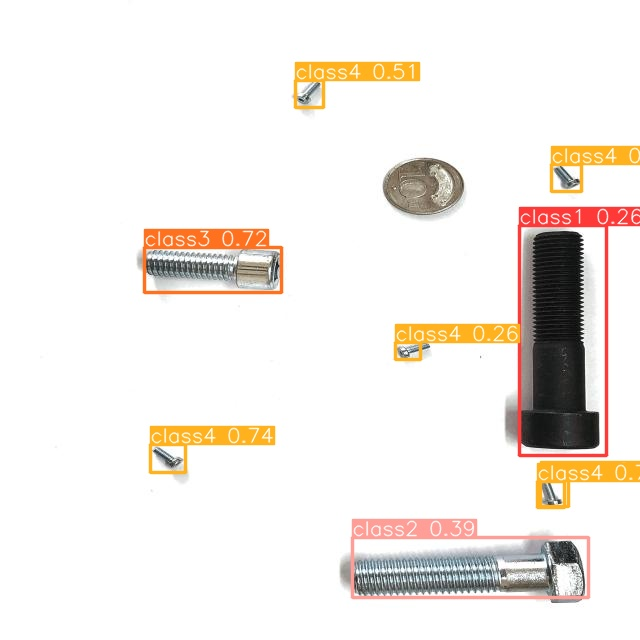

In [11]:
from PIL import Image

# 顯示預測結果
Image.open('runs/detect/predict/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg')

### 2.5.2 使用 Ultralytics Python API 預測(方法二)

In [ ]:
model = YOLO('runs/detect/train/weights/best.pt')

results = model(f'{dataset.location}/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg')

print(results[0].boxes.cls)


image 1/1 /content/screw-4/valid/images/train-3_png.rf.a4bb4fac0eef6076db2f79165d7f6c7b.jpg: 640x640 2 class1s, 1 class2, 6 class4s, 13.3ms
Speed: 1.9ms preprocess, 13.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


tensor([3., 3., 3., 0., 1., 3., 0., 3., 3.], device='cuda:0')


We can visualize our keypoints using the following code:

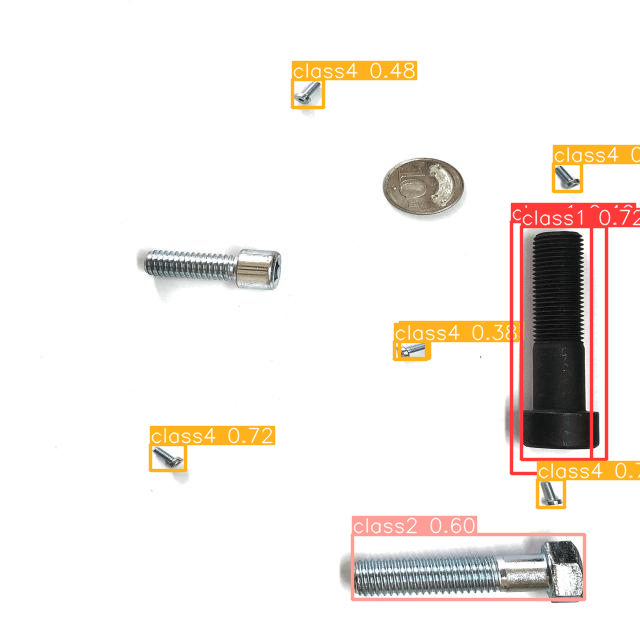

In [ ]:
from PIL import Image

r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
# 顯示預測結果
Image.fromarray(im_array[:,:,::-1], 'RGB')